#### This notebook contains code written by Dr. Rebeckah Fussell that has been modified by Rachel Merrill. ####
##### See https://github.com/rkfussell/NLP_quantum_classical_measurement/blob/main/All_data_model.ipynb?short_path=2151e13 for original code #####

## Activating the environment
This environment has already been set up and the requirements have been installed (locally). If setting up an environment on a different device, see the original code on Dr. Fussell's Github linkd above

cd "C:User/rm854"

then 

conda activate plso

then cd "C:\Users\rm854\Box\Quantum Classical Measurement\Survey 2024\Analysis\Student+Instructor (2025 Spring)\Student-Survey-Coding\BERTCode"

then 

code . 

In [14]:
import sys

# Replace with the full path to the folder containing your .py file
sys.path.append(r"C:\Users\rm854\Box\Quantum Classical Measurement\Survey 2024\Analysis\Student+Instructor (2025 Spring)\Student-Survey-Coding\BERTCode")

import calibration_fns as cal


ModuleNotFoundError: No module named 'calibration_fns'

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer
from torch.utils.data import WeightedRandomSampler 
import torch.nn as nn
from transformers import BertModel
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch.nn.functional as F
import time

import calibration_fns as cal

from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score

ModuleNotFoundError: No module named 'calibration_fns'

In [2]:
cwd = os.getcwd()
data_folder = cwd + '/Prepared_data/'

### Step 1. Set up dataset for pytorch

In [3]:
pd.set_option('display.max_colwidth', None) #prevents columns from truncating

In [4]:
data_sources = pd.read_excel(data_folder + 'data_sources.xlsx')
data_more = pd.read_excel(data_folder + 'data_more.xlsx')
data_better = pd.read_excel(data_folder + 'data_better.xlsx')
data_classical = pd.read_excel(data_folder + 'data_classical.xlsx')
data_quantum = pd.read_excel(data_folder + 'data_quantum.xlsx')
data_twoStudents = pd.read_excel(data_folder + 'data_twoStudents.xlsx')

In [5]:
num_examples = pd.DataFrame({"code": ["P","L","O"],
              "sources": [data_sources["P"].value_counts()[1], data_sources["L"].value_counts()[1], data_sources["O"].value_counts()[1]],
              "more": [data_more["P"].value_counts()[1], data_more["L"].value_counts()[1], data_more["O"].value_counts()[1]],
              "better": [data_better["P"].value_counts()[1], data_better["L"].value_counts()[1], data_better["O"].value_counts()[1]],
              "classical": [data_classical["P"].value_counts()[1], data_classical["L"].value_counts()[1], data_classical["O"].value_counts()[1]],
              "quantum": [data_quantum["P"].value_counts()[1], data_quantum["L"].value_counts()[1], data_quantum["O"].value_counts()[1]],
              "twoStudents": [data_twoStudents["P"].value_counts()[1], data_twoStudents["L"].value_counts()[1], data_twoStudents["O"].value_counts()[1]]
             })
num_examples['sum'] = num_examples[['sources', 'more', 'better','classical','quantum', 'twoStudents']].sum(axis=1)

In [6]:
num_examples

#1. Validation and test sets must be obtained independently, come from the same distribution (training set may be different), that looks as much as possible like the data you expect to observe once deployed in production.
#2. To get decent statistics, validation and test sets must have a few dozen examples of each class


,code,sources,more,better,classical,quantum,twoStudents,sum
0,P,277,275,80,8,109,107,856
1,L,2212,91,279,103,28,79,2792
2,O,410,43,48,58,53,501,1113


What data do we need to reserve for validation and testing? What can we use for training?

1. Validation and test sets must be obtained independently, come from the same distribution (training set may be different), that looks as much as possible like the data you expect to observe once deployed in production.
2. To get decent statistics, validation and test sets must have at least few dozen examples of each class. "The validation and test data are only used to calculate statistics reflecting the performance of the model. Those two sets just need to be large enough to provide reliable statistics. How
much is debatable. As a rule of thumb, having a dozen examples per class is a desirable minimum. If you can have a hundred examples per class in each of the two holdout sets, you have a solid setup and the statistics calculated based on such sets are reliable." (Burkov, 2020)
* Obviously, we cannot hold out a hundred examples per class for P, but if we combine more+better and generic+classical we have 277 P(Sources), 350 P(More/Better), 117 P(Generic), and 107 P(Two Students).
* For L we have 2212 L(Sources), 370 L(More/Better), 131 L(Generic) and 79 L(Two Students)

To keep the distribution for validation and test sets as close as possible to the data we expect to observe in production, we will take clean percentages of the full data set when splitting data between training and validation and test. 

For sources, if we want to be able to validate for P we need at minimum 10% of the data. This will leave us with about 28 examples of P. We can increase this to 20% and get 55 examples of P, which is probably helpful since the dataset is so unbalanced. So we will put 60% of the sources data into training.

For more/better, the minimum number to get decent statistics on P and L would be ~35, which is 10% of the data. If we are worried about training the O model sufficently on the more/better data we might consider increasing our validation+training set sizes to 20%, which again would put 60% of more/better into training.

For generic (classical/quantum), we need at least 20% of the data. That will give us about 23 examples for P and 26 examples for L. Again this leaves 60% of the dataset for training.

For two students, to get a useful/reliable training set we would need 24 examples of L, which is ~30% of the dataset. That would make the training set only 40% of the dataset. This is not ideal, but we simply have a very unbalanced dataset for two students.

In [7]:
data_sources["Question"] = "Sources"
data_more["Question"] = "More"
data_better["Question"] = "Better"
data_classical["Question"] = "Classical"
data_quantum["Question"] = "Quantum"
data_twoStudents["Question"] = "TwoStudents"

#shuffle data so that we choose a truly random training set
data_sources = data_sources.sample(frac=1).reset_index(drop=True)
data_more = data_more.sample(frac=1).reset_index(drop=True)
data_better = data_better.sample(frac=1).reset_index(drop=True)
data_classical = data_classical.sample(frac=1).reset_index(drop=True)
data_quantum = data_quantum.sample(frac=1).reset_index(drop=True)
data_twoStudents = data_twoStudents.sample(frac=1).reset_index(drop=True)

#define function to split data by question (use default percentages which we can override in running the function)
def split_data(dat, test_percent = 0.10, val_percent = 0.10, train_percent = 0.80):
    test_size = int(test_percent*len(dat))
    val_size = int(val_percent*len(dat))
    train_size = int(train_percent*len(dat))
    
    test_data = dat[:test_size]
    val_data = dat[test_size:test_size + val_size]
    train_data = dat[test_size + val_size:]

    return test_data, val_data, train_data

#we split the sets first so there are equal proportions of more+better and classical+quantum in more/better and generic 
(test_sources, val_sources, train_sources) = split_data(data_sources, test_percent = 0.2, val_percent = 0.2, train_percent = 0.6)
(test_more, val_more, train_more) = split_data(data_more, test_percent = 0.2, val_percent = 0.2, train_percent = 0.6)
(test_better, val_better, train_better) = split_data(data_better, test_percent = 0.2, val_percent = 0.2, train_percent = 0.6)
(test_classical, val_classical, train_classical) = split_data(data_classical, test_percent = 0.2, val_percent = 0.2, train_percent = 0.6)
(test_quantum, val_quantum, train_quantum) = split_data(data_quantum, test_percent = 0.2, val_percent = 0.2, train_percent = 0.6)
(test_twoStudents, val_twoStudents, train_twoStudents) = split_data(data_twoStudents, test_percent = 0.3, val_percent = 0.3, train_percent = 0.4)

#building the testing, validation, and training sets. We want the test/validation sets by data type so we can report independent numbers on how well the model performs
test_data_sources = test_sources[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'O']]
test_data_morebetter = pd.concat([test_more, test_better])[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'O']]
test_data_generic = pd.concat([test_classical, test_quantum])[['ResponseId', 'Question','Input', 'P', 'L', 'O']]
test_data_twoStudents = test_twoStudents[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'O']]

val_data_sources = val_sources[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'O']]
val_data_morebetter = pd.concat([val_more, val_better])[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'O']]
val_data_generic = pd.concat([val_classical, val_quantum])[['ResponseId', 'Question','Input', 'P', 'L', 'O']]
val_data_twoStudents = val_twoStudents[['ResponseId', 'Question','Input', 'P', 'L', 'O']]

train_data = pd.concat([train_sources, train_more, train_better, train_classical, train_quantum, train_twoStudents])[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'O']]

In [8]:
#printing the sizes of the test and validation sets by category/code
print("Test sets")
print("Sources")
print(test_data_sources[["P","L","O"]].sum().to_string())
print("More Better")
print(test_data_morebetter[["P","L","O"]].sum().to_string())
print("Generic")
print(test_data_generic[["P","L","O"]].sum().to_string())
print("Two Students")
print(test_data_twoStudents[["P", "L", "O"]].sum().to_string())

print("\nValidation sets")
print("Sources")
print(val_data_sources[["P","L","O"]].sum().to_string())
print("More Better")
print(val_data_morebetter[["P","L","O"]].sum().to_string())
print("Generic")
print(val_data_generic[["P","L","O"]].sum().to_string())
print("Two Students")
print(val_data_twoStudents[["P", "L", "O"]].sum().to_string())


Test sets
Sources
P     55
L    459
O     65
More Better
P    76
L    69
O    18
Generic
P    22
L    30
O    19
Two Students
P     29
L     20
O    153

Validation sets
Sources
P     49
L    438
O     92
More Better
P    67
L    74
O    20
Generic
P    27
L    25
O    20
Two Students
P     35
L     29
O    146


In [9]:
#printing the total sizes of the training, test and validation data sets
print("training data size: " + str(len(train_data)))
print("sources validation data: " + str(len(val_data_sources)))
print("more/better validation data: " + str(len(val_data_morebetter)))
print("generic validation data: " + str(len(val_data_generic)))
print("two students validation data: " + str(len(val_data_twoStudents)))
print("sources test data: " + str(len(test_data_sources)))
print("more/better test data: " + str(len(test_data_morebetter)))
print("generic test data: " + str(len(test_data_generic)))
print("two students test data: " + str(len(test_data_twoStudents)))

training data size: 2653
sources validation data: 579
more/better validation data: 155
generic validation data: 57
two students validation data: 200
sources test data: 579
more/better test data: 155
generic test data: 57
two students test data: 200


In [10]:
def get_max_len(tokenizer, train):
    all_sent = np.array(train.Input.values)
    # Encode data
    encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_sent]
    # Find the maximum length
    max_len = max([len(sent) for sent in encoded_sentences])
    return max_len

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#we use the function defined above to tokenize the training data and return the maximum length for an input to the model based on that
MAX_LEN = get_max_len(tokenizer, train_data) 

In [12]:
print(MAX_LEN)
#maximum length of an input sentence based on tokenizer + training data

354


In [13]:
#removes "extra" whitespace the model will get confused by, standardizes the text
def text_preprocessing_simple(text):
    try:
        text = re.sub(r'\s+', ' ', text).strip()
    except:
        pass
    return text

In [14]:
def preprocessing_for_bert(data, tokenizer, max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_simple(str(sent)),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            padding='max_length',         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation = True)
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [15]:
class Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len, code):
        self.data, self.masks = preprocessing_for_bert(df["Input"], tokenizer, MAX_LEN)
        self.texts = df["Input"].reset_index(drop=True)
        self.labels = torch.tensor(list(df[code]), dtype = torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        mask = self.masks[idx]
        text = self.texts[idx]
        label = self.labels[idx]
        return sample, mask, text, label

In [16]:
train_dataset_P = Dataset(train_data, tokenizer, MAX_LEN, "P")

val_dataset_sources_P = Dataset(val_data_sources, tokenizer, MAX_LEN,"P")
val_dataset_morebetter_P = Dataset(val_data_morebetter, tokenizer, MAX_LEN,"P")
val_dataset_generic_P = Dataset(val_data_generic, tokenizer, MAX_LEN,"P")
val_dataset_twoStudents_P = Dataset(val_data_twoStudents, tokenizer, MAX_LEN, "P")

test_dataset_sources_P = Dataset(test_data_sources, tokenizer, MAX_LEN,"P")
test_dataset_morebetter_P = Dataset(test_data_morebetter, tokenizer, MAX_LEN,"P")
test_dataset_generic_P = Dataset(test_data_generic, tokenizer, MAX_LEN,"P")
test_dataset_twoStudents_P = Dataset(test_data_twoStudents, tokenizer, MAX_LEN, "P")

train_dataset_L = Dataset(train_data, tokenizer, MAX_LEN, "L")

val_dataset_sources_L = Dataset(val_data_sources, tokenizer, MAX_LEN,"L")
val_dataset_morebetter_L = Dataset(val_data_morebetter, tokenizer, MAX_LEN,"L")
val_dataset_generic_L = Dataset(val_data_generic, tokenizer, MAX_LEN,"L")
val_dataset_twoStudents_L = Dataset(val_data_twoStudents, tokenizer, MAX_LEN, "L")

test_dataset_sources_L = Dataset(test_data_sources, tokenizer, MAX_LEN,"L")
test_dataset_morebetter_L = Dataset(test_data_morebetter, tokenizer, MAX_LEN,"L")
test_dataset_generic_L = Dataset(test_data_generic, tokenizer, MAX_LEN,"L")
test_dataset_twoStudents_L = Dataset(test_data_twoStudents, tokenizer, MAX_LEN, "L")

train_dataset_O = Dataset(train_data, tokenizer, MAX_LEN, "O")

val_dataset_sources_O = Dataset(val_data_sources, tokenizer, MAX_LEN,"O")
val_dataset_morebetter_O = Dataset(val_data_morebetter, tokenizer, MAX_LEN,"O")
val_dataset_generic_O = Dataset(val_data_generic, tokenizer, MAX_LEN,"O")
val_dataset_twoStudents_O = Dataset(val_data_twoStudents, tokenizer, MAX_LEN, "O")

test_dataset_sources_O = Dataset(test_data_sources, tokenizer, MAX_LEN,"O")
test_dataset_morebetter_O = Dataset(test_data_morebetter, tokenizer, MAX_LEN,"O")
test_dataset_generic_O = Dataset(test_data_generic, tokenizer, MAX_LEN,"O")
test_dataset_twoStudents_O = Dataset(test_data_twoStudents, tokenizer, MAX_LEN, "O")

In [17]:
len(train_dataset_P)

2653

In [18]:
train_dataset_P[2]

(tensor([  101,  3608, 11426,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [19]:
for data, mask, text, label in train_dataset_P:
    break

In [29]:
#creates a two-row dataframe where row [0] is the number of items in the training data that do *not* have the code and row [1] is the number that do
class_counts_P = train_data.P.value_counts()
class_counts_L = train_data.L.value_counts()
class_counts_O = train_data.O.value_counts()

In [30]:
#creates a tuple with the inverted values of the occurrence v. non-occurence of each code in the training set (higher # = lower weight)
class_weights_P = 1.0 / class_counts_P
class_weights_L = 1.0 / class_counts_L
class_weights_O = 1.0 / class_counts_O

In [34]:
#assigns "weights" to each item in the dataset, with the numbers corresponding to the values from the class_weights calculations
sample_weights_P = [class_weights_P[i] for i in train_data.P.values]
sample_weights_L = [class_weights_L[i] for i in train_data.L.values]
sample_weights_O = [class_weights_O[i] for i in train_data.O.values]

In [36]:
#turns these weights into tensors
class_weights_P = torch.tensor(class_weights_P, dtype=torch.float)
class_weights_L = torch.tensor(class_weights_L, dtype=torch.float)
class_weights_O = torch.tensor(class_weights_O, dtype=torch.float)

C:\Users\rm854\AppData\Local\Temp\ipykernel_24100\2178154759.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_P = torch.tensor(class_weights_P, dtype=torch.float)
C:\Users\rm854\AppData\Local\Temp\ipykernel_24100\2178154759.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_L = torch.tensor(class_weights_L, dtype=torch.float)
C:\Users\rm854\AppData\Local\Temp\ipykernel_24100\2178154759.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_O = torch.tensor(class_weights_O, dtype=torch.float)


In [37]:
#builds a sampler object that preferences the higher weight for each model
train_sampler_P = WeightedRandomSampler(sample_weights_P,len(train_dataset_P), replacement=True)
train_sampler_L = WeightedRandomSampler(sample_weights_L,len(train_dataset_L), replacement=True)
train_sampler_O = WeightedRandomSampler(sample_weights_O,len(train_dataset_O), replacement=True)

In [38]:
#building the dataloaders for each training, test, and validation set
train_dataloader_P = DataLoader(train_dataset_P, batch_size = 16, sampler = train_sampler_P)

val_dataloader_sources_P = DataLoader(val_dataset_sources_P, batch_size = 16) 
val_dataloader_morebetter_P = DataLoader(val_dataset_morebetter_P, batch_size = 16) 
val_dataloader_generic_P = DataLoader(val_dataset_generic_P, batch_size = 16) 
val_dataloader_twoStudents_P = DataLoader(val_dataset_twoStudents_P, batch_size = 16)

test_dataloader_sources_P = DataLoader(test_dataset_sources_P, batch_size = 16) 
test_dataloader_morebetter_P = DataLoader(test_dataset_morebetter_P, batch_size = 16) 
test_dataloader_generic_P = DataLoader(test_dataset_generic_P, batch_size = 16)
test_dataloader_twoStudents_P = DataLoader(test_dataset_twoStudents_P, batch_size = 16)

train_dataloader_L = DataLoader(train_dataset_L, batch_size = 16, sampler = train_sampler_L)

val_dataloader_sources_L = DataLoader(val_dataset_sources_L, batch_size = 16) 
val_dataloader_morebetter_L = DataLoader(val_dataset_morebetter_L, batch_size = 16) 
val_dataloader_generic_L = DataLoader(val_dataset_generic_L, batch_size = 16) 
val_dataloader_twoStudents_L = DataLoader(val_dataset_twoStudents_L, batch_size = 16)

test_dataloader_sources_L = DataLoader(test_dataset_sources_L, batch_size = 16) 
test_dataloader_morebetter_L = DataLoader(test_dataset_morebetter_L, batch_size = 16) 
test_dataloader_generic_L = DataLoader(test_dataset_generic_L, batch_size = 16) 
test_dataloader_twoStudents_L = DataLoader(test_dataset_twoStudents_L, batch_size = 16)

train_dataloader_O = DataLoader(train_dataset_O, batch_size = 16, sampler = train_sampler_O)

val_dataloader_sources_O = DataLoader(val_dataset_sources_O, batch_size = 16) 
val_dataloader_morebetter_O = DataLoader(val_dataset_morebetter_O, batch_size = 16) 
val_dataloader_generic_O = DataLoader(val_dataset_generic_O, batch_size = 16) 
val_dataloader_twoStudents_O = DataLoader(val_dataset_twoStudents_O, batch_size = 16)

test_dataloader_sources_O = DataLoader(test_dataset_sources_O, batch_size = 16) 
test_dataloader_morebetter_O = DataLoader(test_dataset_morebetter_O, batch_size = 16) 
test_dataloader_generic_O = DataLoader(test_dataset_generic_O, batch_size = 16) 
test_dataloader_twoStudents_O = DataLoader(test_dataset_twoStudents_O, batch_size = 16)

In [39]:
for sents, masks, texts, labels in train_dataloader_P:
    break

In [40]:
print(sents.shape)
print(masks.shape)
print(labels.shape)

torch.Size([16, 354])
torch.Size([16, 354])
torch.Size([16])


### Step 2. Set up Pytorch Model

In [41]:
class Classifier(nn.Module):
    def __init__(self, num_classes=2, freeze_bert = False):
        #Where we define all the parts of the model
        super(Classifier, self).__init__()  # initialize object with everything from the parent class
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 200, num_classes
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )
        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    def forward(self, input_ids, attention_mask):
        # Connect these parts and return the output
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        return logits

Test that an example model takes inputs

In [42]:
model_P = Classifier(num_classes = 2)
print(model_P)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

C:\Users\rm854\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rm854\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [43]:
example_out = model_P(sents, masks)

C:\Users\rm854\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [44]:
example_out.shape #batch size, num_classes

torch.Size([16, 2])

In [45]:
example_out

tensor([[-0.1164, -0.2030],
        [-0.1151, -0.2682],
        [-0.0645, -0.2723],
        [-0.1180, -0.2312],
        [-0.0812, -0.2395],
        [-0.1405, -0.2771],
        [-0.0821, -0.2642],
        [ 0.0227, -0.3211],
        [-0.1333, -0.2723],
        [-0.0291, -0.2969],
        [-0.1453, -0.2333],
        [-0.0550, -0.2353],
        [-0.0483, -0.3003],
        [-0.1174, -0.2455],
        [-0.0129, -0.2431],
        [-0.0842, -0.2727]], grad_fn=<AddmmBackward0>)

### Step 3. The training loop

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")
print(device)

cuda:0


In [30]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_P)

In [31]:
criterion(example_out, labels) # check that the loss function calculates. It won't be any good yet because we haven't done training

tensor(0.7697, grad_fn=<NllLossBackward0>)

In [32]:
labels

tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1])

In [34]:
def training_loop(train_dataloader, val_dataloader1, val_dataloader2, val_dataloader3, class_weights, num_epochs = 5, lr = 1e-5, weight_decay = 1e-5):
    
    num_epochs = 7
    train_losses, val_losses1, val_losses2, val_losses3 = [], [], [], []
    
    model = Classifier(num_classes=2)
    model.to(device)
    
    total_steps = len(train_dataloader) * num_epochs # Total number of training steps
    
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=0, # Default value
                                                    num_training_steps=total_steps)
    
    loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    
    for epoch in range(num_epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        running_loss = 0.0
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0 # Reset tracking variables at the beginning of each epoch
        model.train() # Set the model to train
        for batch_idx, (sents, masks, texts, labels) in enumerate(train_dataloader): 
            batch_counts +=1
            sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad() # set our optimizer to zero_grad
            outputs = model(sents, masks) # get our outputs by calling the forward method on the images
            loss = loss_fn(outputs, labels)
            loss.backward() # this is where we do backpropagation on the model to update the model weights
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step()
            scheduler.step()
            #print(f"Batch {batch_idx}: Loss = {loss.item()}")
            batch_loss += loss.item()
            running_loss += loss.item() * sents.size(0)
            # Print the loss values and time elapsed for every 20 batches
            if (batch_idx % 20 == 0 and batch_idx != 0) or (batch_idx == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                # Print training results
                print(f"{epoch + 1:^7} | {batch_idx:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()
        train_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)
        print("-"*70)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        val_accuracy1 = []
        with torch.no_grad(): #to make sure the model weights are not touched
            for sents, masks, texts, labels in val_dataloader1:
                sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
                outputs = model(sents, masks)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item() * sents.size(0)
                # Get the predictions
                preds = torch.argmax(outputs, dim=1).flatten()
                # Calculate the accuracy rate
                accuracy = (preds == labels).cpu().numpy().mean() * 100
                val_accuracy1.append(accuracy)
                time_elapsed = time.time() - t0_epoch
        val_loss1 = running_loss / len(val_dataloader1.dataset)
        val_losses1.append(val_loss1)
        val_accuracy1 = np.mean(val_accuracy1)
    
        #Print epoch stats
        print(f"{'Epoch':^7} | {'Dataset':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        print(f"{epoch+1:^7} | {'Sources':^7} | {train_loss:^12.6f} | {val_loss1:^10.6f} | {val_accuracy1:^9.2f} | {time_elapsed:^9.2f}")
        
        running_loss = 0.0
        val_accuracy2 = []
        with torch.no_grad(): #to make sure the model weights are not touched
            for sents, masks, texts, labels in val_dataloader2:
                sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
                outputs = model(sents, masks)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item() * sents.size(0)
                # Get the predictions
                preds = torch.argmax(outputs, dim=1).flatten()
                # Calculate the accuracy rate
                accuracy = (preds == labels).cpu().numpy().mean() * 100
                val_accuracy2.append(accuracy)
                time_elapsed = time.time() - t0_epoch
        val_loss2 = running_loss / len(val_dataloader2.dataset)
        val_losses2.append(val_loss2)
        val_accuracy2 = np.mean(val_accuracy2)
    
        #Print epoch stats
        print(f"{epoch+1:^7} | {'MB':^7} | {train_loss:^12.6f} | {val_loss2:^10.6f} | {val_accuracy2:^9.2f} | {time_elapsed:^9.2f}")

        running_loss = 0.0
        val_accuracy3 = []
        with torch.no_grad(): #to make sure the model weights are not touched
            for sents, masks, texts, labels in val_dataloader3:
                sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
                outputs = model(sents, masks)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item() * sents.size(0)
                # Get the predictions
                preds = torch.argmax(outputs, dim=1).flatten()
                # Calculate the accuracy rate
                accuracy = (preds == labels).cpu().numpy().mean() * 100
                val_accuracy3.append(accuracy)
                time_elapsed = time.time() - t0_epoch
        val_loss3 = running_loss / len(val_dataloader3.dataset)
        val_losses3.append(val_loss3)
        val_accuracy3 = np.mean(val_accuracy3)
    
        #Print epoch stats
        print(f"{epoch+1:^7} | {'Generic':^7} | {train_loss:^12.6f} | {val_loss3:^10.6f} | {val_accuracy3:^9.2f} | {time_elapsed:^9.2f}")

    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses1, label='Validation loss 1')
    plt.plot(val_losses2, label='Validation loss 2')
    plt.plot(val_losses3, label='Validation loss 3')
    plt.legend()
    plt.title("Loss over epochs")
    plt.show()

    return model

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.417668   |     -      |     -     |   3.02   
   1    |   40    |   0.341299   |     -      |     -     |   4.66   
   1    |   60    |   0.290506   |     -      |     -     |   6.30   
   1    |   80    |   0.247788   |     -      |     -     |   7.95   
   1    |   100   |   0.218084   |     -      |     -     |   9.59   
   1    |   120   |   0.201616   |     -      |     -     |   11.24  
   1    |   139   |   0.182656   |     -      |     -     |   12.79  
----------------------------------------------------------------------
 Epoch  | Dataset |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    | Sources |   0.183362   |  0.238695  |   92.74   |   13.68  
   1    |   MB    |   0.183362   |  0.481169  |   77.18   |   14.05  
   1    | Generic

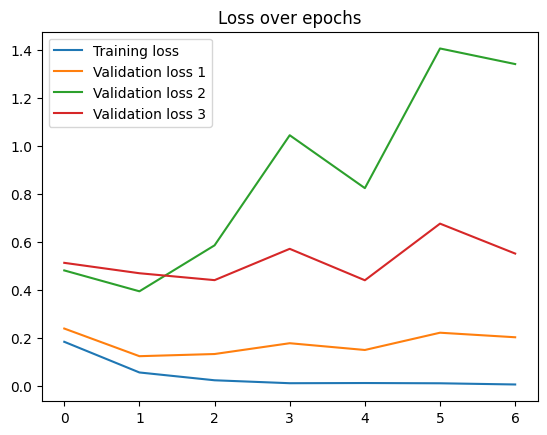

In [35]:
#run training loop for "P"
model_P = training_loop(train_dataloader_P, val_dataloader_sources_P, val_dataloader_morebetter_P, val_dataloader_generic_P, val_dataloader_twoStudents_P, class_weights_P)

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.632092   |     -      |     -     |   1.75   
   1    |   40    |   0.587011   |     -      |     -     |   3.41   
   1    |   60    |   0.546401   |     -      |     -     |   5.07   
   1    |   80    |   0.506074   |     -      |     -     |   6.74   
   1    |   100   |   0.479026   |     -      |     -     |   8.41   
   1    |   120   |   0.458075   |     -      |     -     |   10.07  
   1    |   139   |   0.430367   |     -      |     -     |   11.62  
----------------------------------------------------------------------
 Epoch  | Dataset |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    | Sources |   0.431928   |  0.297245  |   86.60   |   12.51  
   1    |   MB    |   0.431928   |  0.763705  |   70.69   |   12.88  
   1    | Generic

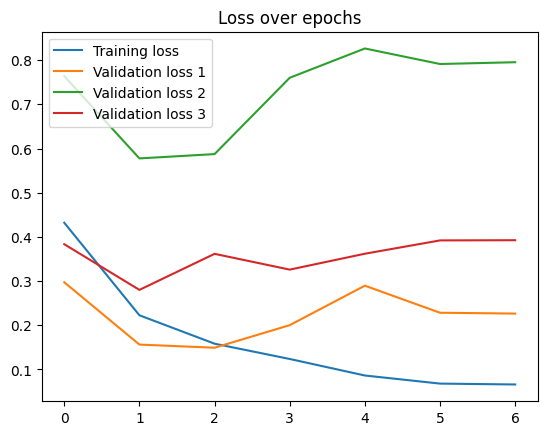

In [36]:
#run training loop for "L"
model_L = training_loop(train_dataloader_L, val_dataloader_sources_L, val_dataloader_morebetter_L, val_dataloader_generic_L, val_dataloader_twoStudents_L, class_weights_L)

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.534716   |     -      |     -     |   1.78   
   1    |   40    |   0.482415   |     -      |     -     |   3.46   
   1    |   60    |   0.440018   |     -      |     -     |   5.15   
   1    |   80    |   0.416385   |     -      |     -     |   6.85   
   1    |   100   |   0.394592   |     -      |     -     |   8.55   
   1    |   120   |   0.377332   |     -      |     -     |   10.24  
   1    |   139   |   0.359850   |     -      |     -     |   11.81  
----------------------------------------------------------------------
 Epoch  | Dataset |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    | Sources |   0.361113   |  0.541474  |   72.24   |   12.75  
   1    |   MB    |   0.361113   |  1.476663  |   14.58   |   13.12  
   1    | Generic

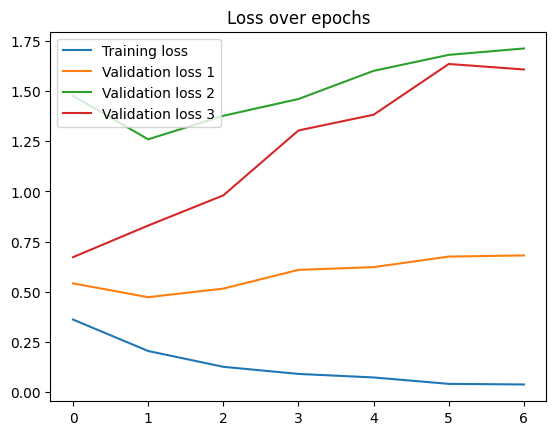

In [38]:
#run training loop for "O"
model_O = training_loop(train_dataloader_O, val_dataloader_sources_O, val_dataloader_morebetter_O, val_dataloader_generic_O, val_dataloader_twoStudents_O, class_weights_O)

## Save the model state dictionaries and tokenizer

In [ ]:
#save the state dictionaries for the model
torch.save(model_P.state_dict(), "modelP.pth")
torch.save(model_L.state_dict(), "modelL.pth")
torch.save(model_O.state_dict(), "modelO.pth")

In [40]:
#save the tokenizer for the model
tokenizer.save_pretrained('my_tokenizer/')